This code implements a simple Bayesian forward model for a hypothetical electron spectrometer with simple Gaussian response functions. The energy channel midles and widths are taken from the MagEIS LOW detector.

Overall, this code creates the fake population and observed counts from a spectra specified by the user for validation purposes. Then the model conists of specifing the prior which is taken to be uniform distributions of  E0  and  J0 . The likeleyhood is then the integral of the sampled spectra folded through the instrument response.

Since there are 7 energy channels, I've had to specify the folding step into a function in order for this model to work in pymc3.

The Gaussain instrument response for the spectrometer (loosely based on MagEIS) is found in mageis_response.py

The code was inspired by Isaac Michaud ijmichau@ncsu.edu.

In [4]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../frequentist')
import mageis_response

# Make a fake spectra and get the true counts. Then draw the "observed" counts assuming a Poisson process.

In [7]:
# Spectra parameters
E0t = 100
J0t = 200 

# Reponse parameters
R0 = 3000

# Energy array to descritize the spectra and response function
Earr = np.linspace(1, 300, num=1000) 
dE = Earr[1] - Earr[0] # To do the integral.

# Initate the response function
R = mageis_response.R_gaus()

def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

def true_spectra(Earr, J0t, E0t):
    return spectra(Earr, J0t, E0t)

true_lambda = np.nan*np.zeros(7)

for i in range(7):
    true_lambda[i] = dE*np.dot(true_spectra(Earr, J0t, E0t), 
                               R.response(R0=R0, Earr=Earr, ch=i))

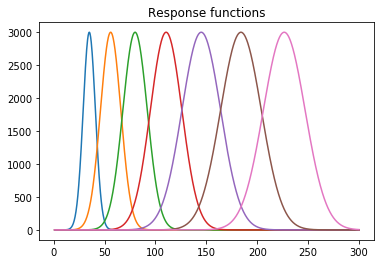

In [8]:
for i in range(7):
    plt.plot(Earr, R.response(R0=R0, Earr=Earr, ch=i))
plt.title('Response functions');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [9]:
np.random.seed(123) # For reproducability.
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertnaity, and the counts that could have been observed if we assume a poisson process

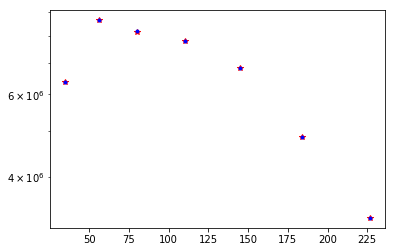

In [11]:
plt.plot(R.mu, true_lambda, 'r*', label=r'$\lambda$ population')
plt.plot(R.mu, c_obs, 'b.', label='Observed counts')
plt.yscale('log')

Looks like the c_obs and lambda counts are essentially on top of each other.



# Bayes model


In [36]:
m = pm.Model()

def lam(J0, E0):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response.
    """
    lams = 7*[None]
    for i in range(len(c_obs)):
        lams[i] = pm.Deterministic(
            'lam{}'.format(i),
            dE*pm.math.dot(J, R.response(R0=R0, Earr=Earr, ch=i))
                              )
    return lams

with m:
    # Prior stocastic variables
    J0 = pm.Uniform('J0', lower=1, upper=1E6)
    E0 = pm.Uniform('E0', lower=1, upper=500)
    
    # Define an exponential spectra
    #J = pm.Deterministic('J', J0*pm.math.exp(-Earr/E0)) # I don't think it needs to be Deterministic
    J = J0*pm.math.exp(-Earr/E0)
    
    lams = lam(J0, E0)
    c_m = pm.Poisson('c_m{}'.format(i), mu=lams, observed=c_obs)
    trace = pm.sample(1E5, tuning=2000, cores=3, step=pm.Metropolis())

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [E0_interval__]
>Metropolis: [J0_interval__]
100%|██████████| 100500/100500.0 [01:08<00:00, 1469.29it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


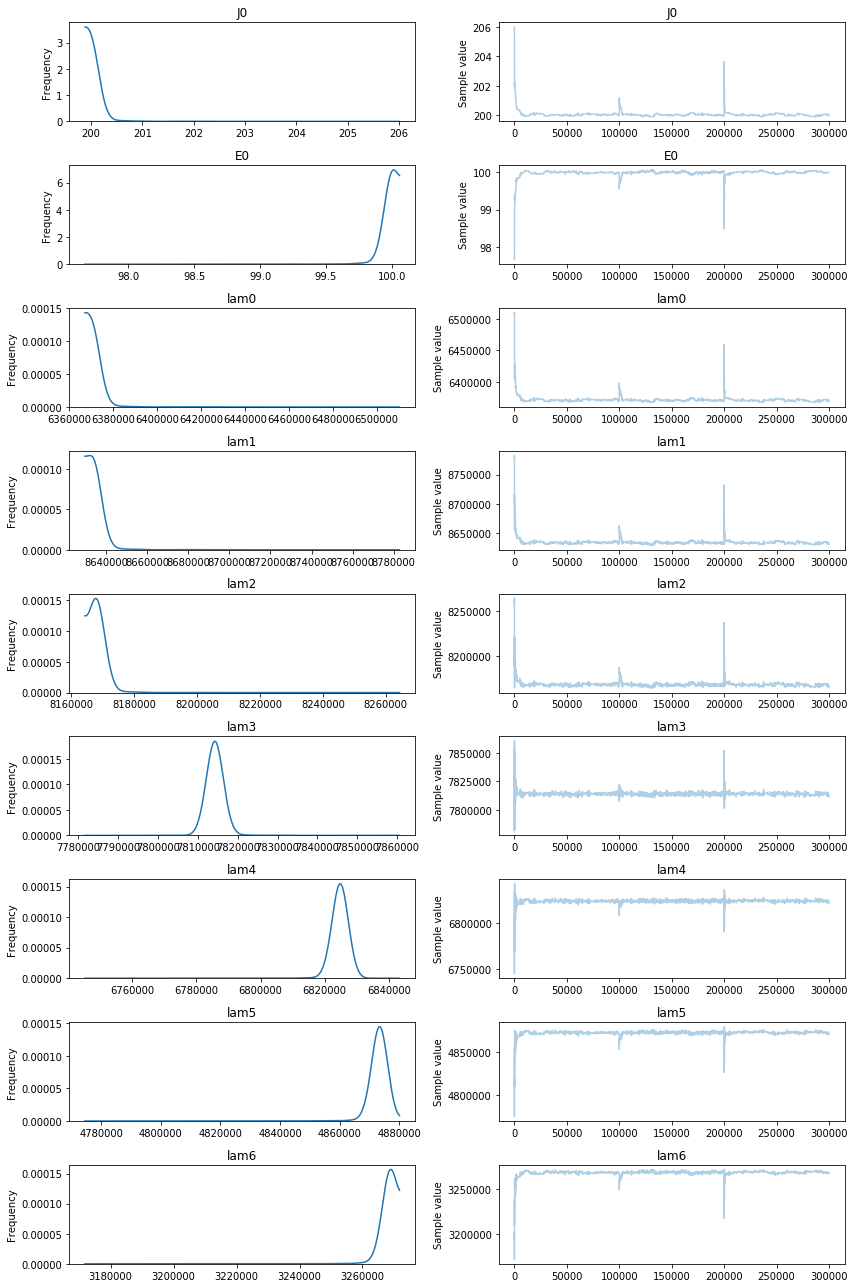

In [37]:
pm.traceplot(trace, combined=True);

In [38]:
pm.summary(trace)

mean           sd    mc_error       hpd_2.5      hpd_97.5  \
J0    2.000442e+02     0.184172    0.013613  1.999085e+02  2.001658e+02   
E0    9.997690e+01     0.072918    0.005575  9.993238e+01  1.000427e+02   
lam0  6.371360e+06  4280.870753  309.621714  6.368223e+06  6.374418e+06   
lam1  8.634720e+06  4573.127524  321.361198  8.631031e+06  8.638052e+06   
lam2  8.168279e+06  3050.992722  197.403576  8.165328e+06  8.170874e+06   
lam3  7.814146e+06  1719.410549   68.208762  7.811683e+06  7.816245e+06   
lam4  6.824336e+06  1660.207270   87.061065  6.821629e+06  6.826536e+06   
lam5  4.872704e+06  2291.003036  164.015649  4.870213e+06  4.875424e+06   
lam6  3.268017e+06  2490.696273  186.628100  3.265891e+06  3.270748e+06   

           n_eff      Rhat  
J0     98.084193  1.009986  
E0     88.690519  1.013837  
lam0  103.510345  1.008531  
lam1  110.928803  1.007058  
lam2  135.544701  1.004208  
lam3  519.941245  1.000136  
lam4  193.609579  1.015236  
lam5   95.838402  1.018119  
lam6   89.200902  1.017083

In [39]:
np.mean(trace['lam0'])

6371359.796052944

In [40]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]

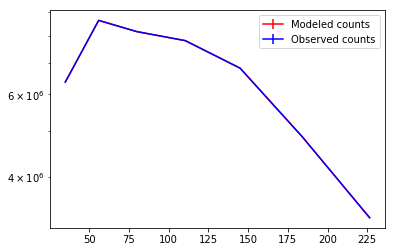

In [41]:
plt.errorbar(R.mu, c_mean, yerr=c_std, c='r', label='Modeled counts'); 
plt.errorbar(R.mu, c_obs, yerr=np.sqrt(c_obs), c='b', label='Observed counts'); 
plt.yscale('log'); plt.legend();

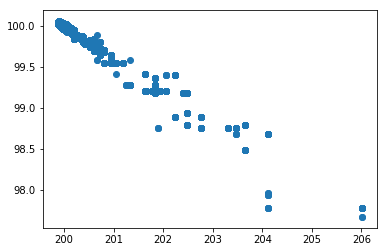

In [42]:
plt.scatter(trace['J0'], trace['E0']);

True value is 200


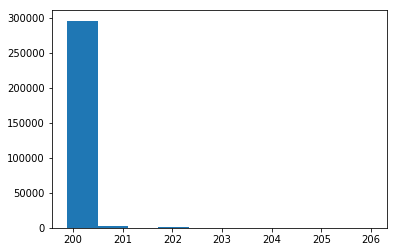

In [43]:
plt.hist(trace['J0']); print('True value is', J0t)

In [44]:
plt.hist(trace['E0']); print('True value is', E0t)

True value is 100
